In [2]:
!pip install openeo rasterio folium geopandas sentinelhub matplotlib seaborn plotly requests

In [3]:
import openeo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
import rasterio
from datetime import datetime, timedelta
import folium
from sentinelhub import SHConfig, BBox, CRS, MimeType, DataCollection, SentinelHubRequest, bbox_to_dimensions
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from io import BytesIO
from PIL import Image
warnings.filterwarnings('ignore')


C:\Users\manop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
lago_atitlan = {
    "west": -91.326256,
    "east": -91.07151,
    "south": 14.5948,
    "north": 14.750979
}

lago_amatitlan = {
    "west": -90.638065,
    "east": -90.512924,
    "south": 14.412347,
    "north": 14.493799
}
start_date = "2024-01-01"
end_date = "2024-07-31"

print(f"Período de análisis: {start_date} a {end_date}")
duration = (datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days
print(f"Duración: {duration} días ({duration/30:.1f} meses)")


Período de análisis: 2024-01-01 a 2024-07-31
Duración: 212 días (7.1 meses)


In [5]:
def setup_real_connections():
    try:
        connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
        
        collections = connection.list_collections()
        sentinel_collections = []
        for c in collections:
            try:
                if 'sentinel' in c['id'].lower():
                    sentinel_collections.append(c['id'])
            except Exception:
                continue
        
        print(f"Colecciones Sentinel disponibles: {len(sentinel_collections)}")

        config = SHConfig()
        config.sh_client_id = 'c02eac78-6a59-4c33-b10e-bfbc596293f8'
        config.sh_client_secret = 'uy82TTniaWG15EYJsq2h8DRQpod3Beer'
        config.save()
        print("Configuración Sentinel Hub guardada")
        
        return connection, config
    except Exception as e:
        print(f"Error en configuración: {e}")
        return None, None


In [6]:
cyanobacteria_evalscript = """
//VERSION=3
// Cyanobacteria detection script
// Based on official Sentinel Hub script from custom-scripts repository

function setup() {
    return {
        input: ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
        output: { 
            bands: 4,
            sampleType: "FLOAT32"
        }
    };
}

// Water body detection function
function isWater(sample) {
    let mndwi = (sample.B03 - sample.B11) / (sample.B03 + sample.B11 + 0.001);
    let ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08 + 0.001);
    let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + 0.001);
    
    // Water detection criteria
    return (mndwi > 0.42 || ndwi > 0.4 || ndvi < -0.2);
}

function evaluatePixel(sample) {
    let water = isWater(sample) ? 1.0 : 0.0;
    
    if (water > 0) {
        // NDCI (Normalized Difference Chlorophyll Index)
        let ndci = (sample.B05 - sample.B04) / (sample.B05 + sample.B04 + 0.001);
        
        // FAI (Floating Algal Index) 
        let fai = sample.B07 - sample.B04 - (sample.B8A - sample.B04) * (783 - 665) / (865 - 665);
        
        // Chlorophyll-a concentration (cyanobacteria proxy)
        let chl_a = Math.max(0, 826.57 * Math.pow(ndci, 3) - 176.43 * Math.pow(ndci, 2) + 19 * ndci + 4.071);
        chl_a = Math.min(chl_a, 100); // Cap at 100 μg/L
        
        // Additional spectral indices
        let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04 + 0.001);
        let ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08 + 0.001);
        
        return [chl_a, ndci, fai, ndwi];
    } else {
        return [0.0, 0.0, 0.0, 0.0];
    }
}
"""

In [7]:
def create_sentinel_hub_request(bbox, time_range, config):
    try:
        bbox_coords = BBox(
            bbox=[bbox['west'], bbox['south'], bbox['east'], bbox['north']], 
            crs=CRS.WGS84
        )
        size = bbox_to_dimensions(bbox_coords, resolution=60)
        
        request = SentinelHubRequest(
            evalscript=cyanobacteria_evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_range,
                    mosaicking_order='leastCC',
                    maxcc=0.3
                )
            ],
            responses=[
                SentinelHubRequest.output_response('default', MimeType.TIFF)
            ],
            bbox=bbox_coords,
            size=size,
            config=config,
            data_folder='data'
        )
        
        return request, size
        
    except Exception as e:
        print(f"Error creando solicitud Sentinel Hub: {e}")
        return None, None


In [8]:
def download_sentinel_hub_data(request, lake_name):
    try:
        print(f"Descargando datos de Sentinel Hub para {lake_name}...")
        response = request.get_data(save_data=True)
        
        if response and len(response) > 0:
            data = response[0]
            
            print(f" Datos descargados para {lake_name}")
            print(f"  Forma: {data.shape}")
            print(f"  Tipo: {data.dtype}")
            chl_a = data[:, :, 0]
            ndci = data[:, :, 1]
            fai = data[:, :, 2]  
            ndwi = data[:, :, 3]      
            water_mask = (chl_a > 0).astype(float)
            
            return {
                'chl_a': chl_a,
                'ndci': ndci,
                'fai': fai,
                'ndwi': ndwi,
                'water_mask': water_mask,
                'shape': data.shape
            }
        else:
            print(f"No se obtuvieron datos para {lake_name}")
            return None
            
    except Exception as e:
        print(f"Error descargando datos para {lake_name}: {e}")
        return None

In [9]:
def download_openeo_data(connection, bbox, start_date, end_date, lake_name):
    try:
        print(f"Descargando datos OpenEO para {lake_name}...")
        datacube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent={
                "west": bbox["west"], 
                "east": bbox["east"], 
                "south": bbox["south"], 
                "north": bbox["north"]
            },
            temporal_extent=[start_date, end_date],
            bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
        )

        datacube = datacube.filter_bbox(**bbox)
        datacube = datacube.resample_spatial(resolution=60)
        job = datacube.create_job(
            title=f"Cyanobacteria_Analysis_{lake_name}",
            description=f"Descarga de datos Sentinel-2 para análisis de cianobacterias en {lake_name}"
        )
        print("Ejecutando...")

        job.start_and_wait()
        
        if job.status() == "finished":
            results = job.get_results()
            print(f"Descarga completada para {lake_name}")
            return results
        else:
            print(f"Job falló para {lake_name}: {job.status()}")
            return None
            
    except Exception as e:
        print(f"Error OpenEO para {lake_name}: {e}")
        return None


In [10]:
def process_real_data(data_dict, lake_name):
    if data_dict is None:
        return None
        
    try:
        chl_a = data_dict['chl_a']
        water_mask = data_dict['water_mask']
        water_pixels = chl_a[water_mask > 0]
        
        if len(water_pixels) > 0:
            stats = {
                'mean_chl_a': np.mean(water_pixels),
                'max_chl_a': np.max(water_pixels),
                'min_chl_a': np.min(water_pixels),
                'std_chl_a': np.std(water_pixels),
                'water_pixel_count': len(water_pixels),
                'total_pixels': chl_a.size,
                'water_percentage': len(water_pixels) / chl_a.size * 100
            }
            
            print(f"Clorofila-a promedio: {stats['mean_chl_a']:.2f} μg/L")
            print(f"Clorofila-a máxima: {stats['max_chl_a']:.2f} μg/L")
            print(f"Píxeles de agua: {stats['water_pixel_count']} ({stats['water_percentage']:.1f}%)")
            
            return stats
        else:
            print(f"No se detectaron píxeles de agua en {lake_name}")
            return None
            
    except Exception as e:
        print(f"Error procesando datos de {lake_name}: {e}")
        return None

In [11]:
def download_temporal_data(connection, config, bbox, lake_name, start_date, end_date, frequency='30D'):
    temporal_data = {}
    dates = pd.date_range(start=start_date, end=end_date, freq=frequency)
    
    print(f"\nDescargando serie temporal para {lake_name}")
    print(f"Fechas a procesar: {len(dates)}")
    
    for i, date in enumerate(dates):
        try:
            start_window = (date - timedelta(days=7)).strftime('%Y-%m-%d')
            end_window = (date + timedelta(days=7)).strftime('%Y-%m-%d')
            
            print(f"procesando fecha {i+1}/{len(dates)}: {date.strftime('%Y-%m-%d')}")

            request, size = create_sentinel_hub_request(
                bbox, 
                (start_window, end_window), 
                config
            )
            
            if request:
                data = download_sentinel_hub_data(request, f"{lake_name}_{date.strftime('%Y%m%d')}")
                
                if data:
                    temporal_data[date.strftime('%Y-%m-%d')] = {
                        'date': date,
                        'data': data,
                        'stats': process_real_data(data, f"{lake_name}_{date.strftime('%Y-%m-%d')}")
                    }
                    print(f"Datos guardados para {date.strftime('%Y-%m-%d')}")
                else:
                    print(f"mo hay datos para {date.strftime('%Y-%m-%d')}")
            import time
            time.sleep(2)
            
        except Exception as e:
            print(f"Error procesando {date.strftime('%Y-%m-%d')}: {e}")
            continue
    
    print(f"Serie temporal completada: {len(temporal_data)} fechas exitosas")
    return temporal_data

In [12]:
def analyze_real_temporal_data(temporal_data, lake_name):
    dates = []
    mean_chl_a = []
    max_chl_a = []
    water_pixels = []
    
    for date_str, entry in temporal_data.items():
        if entry['stats']:
            dates.append(pd.to_datetime(date_str))
            mean_chl_a.append(entry['stats']['mean_chl_a'])
            max_chl_a.append(entry['stats']['max_chl_a'])
            water_pixels.append(entry['stats']['water_pixel_count'])
    
    if len(dates) == 0:
        print(f"No hay datos válidos para análisis temporal de {lake_name}")
        return None
    
    df = pd.DataFrame({
        'date': dates,
        'mean_chl_a': mean_chl_a,
        'max_chl_a': max_chl_a,
        'water_pixels': water_pixels
    })
    if len(mean_chl_a) > 0:
        threshold = np.percentile(mean_chl_a, 75)
        df['bloom_event'] = df['mean_chl_a'] > threshold
        
        print(f"\nANÁLISIS TEMPORAL - {lake_name.upper()}")
        print(f"Observaciones válidas: {len(df)}")
        print(f"Concentración promedio: {np.mean(mean_chl_a):.2f} μg/L")
        print(f"Concentración máxima: {np.max(max_chl_a):.2f} μg/L")
        print(f"Eventos de floración: {df['bloom_event'].sum()}")
    
    return df

In [13]:
def plot_real_temporal_evolution(df_atitlan, df_amatitlan):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    if df_atitlan is not None and len(df_atitlan) > 0:
        axes[0,0].plot(df_atitlan['date'], df_atitlan['mean_chl_a'], 'b-o', 
                      label='Atitlán', markersize=6, linewidth=2)
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        axes[0,0].plot(df_amatitlan['date'], df_amatitlan['mean_chl_a'], 'r-s', 
                      label='Amatitlán', markersize=6, linewidth=2)
    
    axes[0,0].set_title('Evolución Temporal - Clorofila-a Promedio', fontsize=12)
    axes[0,0].set_ylabel('Clorofila-a')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    if df_atitlan is not None and len(df_atitlan) > 0:
        axes[0,1].plot(df_atitlan['date'], df_atitlan['max_chl_a'], 'b-o', 
                      label='Atitlán', markersize=6, linewidth=2)
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        axes[0,1].plot(df_amatitlan['date'], df_amatitlan['max_chl_a'], 'r-s', 
                      label='Amatitlán', markersize=6, linewidth=2)
    
    axes[0,1].set_title('Evolución Temporal - Clorofila-a Máxima', fontsize=12)
    axes[0,1].set_ylabel('Clorofila-a')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    if df_atitlan is not None and len(df_atitlan) > 0:
        bloom_atitlan = df_atitlan[df_atitlan['bloom_event']]
        axes[1,0].scatter(bloom_atitlan['date'], bloom_atitlan['mean_chl_a'], 
                         c='blue', s=100, alpha=0.8, label=f'Atitlán ({len(bloom_atitlan)} eventos)')
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        bloom_amatitlan = df_amatitlan[df_amatitlan['bloom_event']]
        axes[1,0].scatter(bloom_amatitlan['date'], bloom_amatitlan['mean_chl_a'], 
                         c='red', s=100, alpha=0.8, label=f'Amatitlán ({len(bloom_amatitlan)} eventos)')
    
    axes[1,0].set_title('Eventos de Floración Detectados', fontsize=12)
    axes[1,0].set_ylabel('Clorofila-a')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)
    if df_atitlan is not None and len(df_atitlan) > 0:
        axes[1,1].hist(df_atitlan['mean_chl_a'], bins=10, alpha=0.6, 
                      label='Atitlán', color='blue', density=True)
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        axes[1,1].hist(df_amatitlan['mean_chl_a'], bins=10, alpha=0.6, 
                      label='Amatitlán', color='red', density=True)
    
    axes[1,1].set_title('Distribución de Concentraciones', fontsize=12)
    axes[1,1].set_xlabel('Clorofila-a')
    axes[1,1].set_ylabel('Densidad')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle('ANÁLISIS TEMPORAL', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

def create_real_spatial_map(temporal_data, lake_name, bbox):
    if not temporal_data:
        print(f"No hay datos espaciales para {lake_name}")
        return
    first_date = list(temporal_data.keys())[0]
    data_entry = temporal_data[first_date]
    
    if data_entry['data'] is None:
        print(f"No hay datos espaciales válidos para {lake_name}")
        return
    
    chl_a = data_entry['data']['chl_a']
    water_mask = data_entry['data']['water_mask']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    im1 = axes[0].imshow(chl_a, cmap='RdYlBu_r', vmin=0, vmax=np.percentile(chl_a[chl_a > 0], 95))
    axes[0].set_title(f'{lake_name} - Clorofila-a\n{first_date}')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='.')
    im2 = axes[1].imshow(water_mask, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f'{lake_name} - Máscara de Agua\n{first_date}')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='Agua (0-1)')
    
    plt.tight_layout()
    plt.show()


Colecciones Sentinel disponibles: 12
Configuración Sentinel Hub guardada

Descargando serie temporal para Atitlán
Fechas a procesar: 5
procesando fecha 1/5: 2024-01-01
Descargando datos de Sentinel Hub para Atitlán_20240101...
 Datos descargados para Atitlán_20240101
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.87 μg/L
Clorofila-a máxima: 100.00 μg/L
Píxeles de agua: 29981 (22.6%)
Datos guardados para 2024-01-01
procesando fecha 2/5: 2024-02-15
Descargando datos de Sentinel Hub para Atitlán_20240215...
 Datos descargados para Atitlán_20240215
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.16 μg/L
Clorofila-a máxima: 100.00 μg/L
Píxeles de agua: 26119 (19.7%)
Datos guardados para 2024-02-15
procesando fecha 3/5: 2024-03-31
Descargando datos de Sentinel Hub para Atitlán_20240331...
 Datos descargados para Atitlán_20240331
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.99 μg/L
Clorofila-a máxima: 80.66 μg/L
Píxeles de agua: 28657 (21.6%)
D

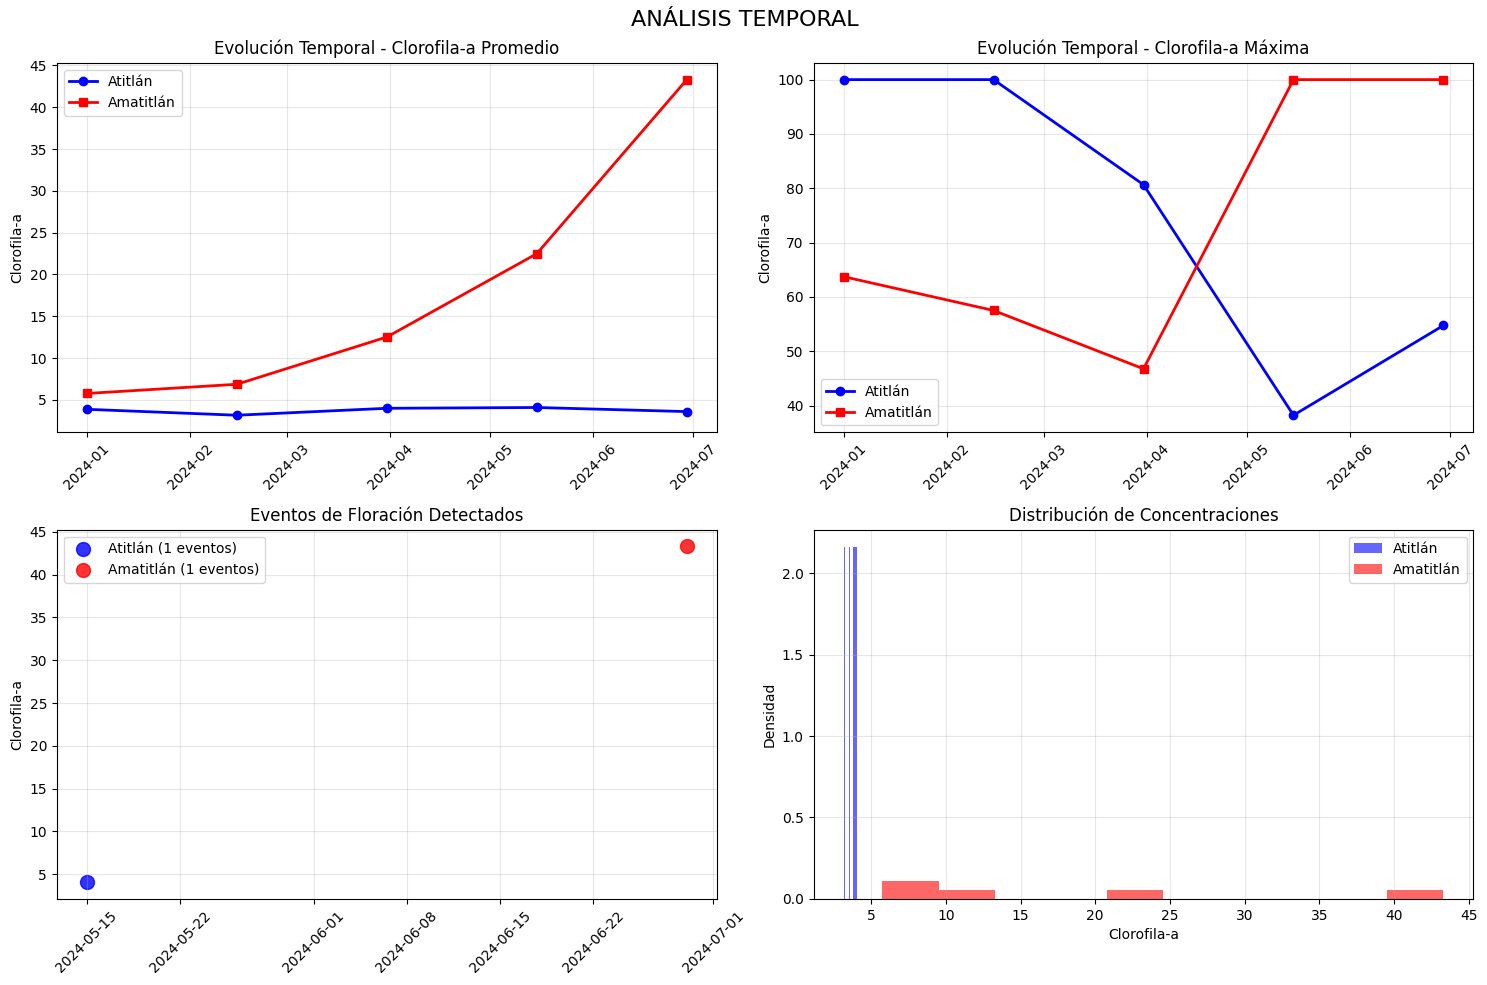

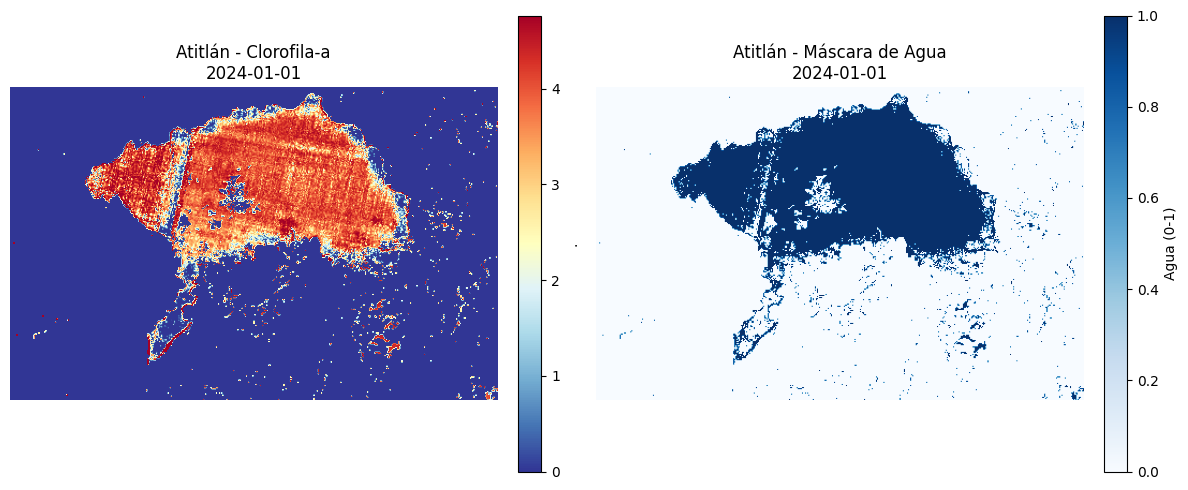

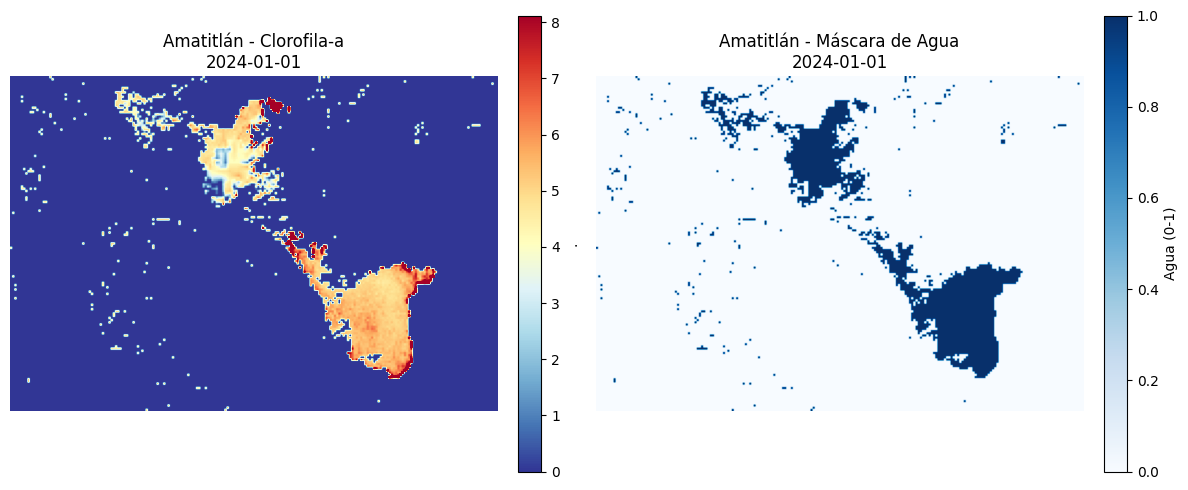

RESUMEN

LAGO ATITLÁN :
   Observaciones válidas: 5
   Concentración promedio: 3.74 μg/L
   Concentración máxima: 100.00 μg/L
   Eventos de floración: 1

 LAGO AMATITLÁN :
   Observaciones válidas: 5
   Concentración promedio: 18.18 μg/L
   Concentración máxima: 100.00 μg/L
   Eventos de floración: 1


{'connection': <Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>,
 'config': SHConfig(
   instance_id='',
   sh_client_id='********************************93f8',
   sh_client_secret='****************************Beer',
   sh_base_url='https://services.sentinel-hub.com',
   sh_auth_base_url=None,
   sh_token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
   geopedia_wms_url='https://service.geopedia.world',
   geopedia_rest_url='https://www.geopedia.world/rest',
   aws_access_key_id='',
   aws_secret_access_key='',
   aws_session_token='',
   aws_metadata_url='https://roda.sentinel-hub.com',
   aws_s3_l1c_bucket='sentinel-s2-l1c',
   aws_s3_l2a_bucket='sentinel-s2-l2a',
   opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
   max_wfs_records_per_query=100,
   max_opensearch_records_per_query=500,
   max_download_attempts=4,
   download_sleep_time=5.0,
   download_timeout_seconds=12

In [14]:
def main_real_analysis():
    connection, config = setup_real_connections()
    
    if connection is None or config is None:
        print("No se pudieron establecer las conexiones")
        return None
    
    try:
        temporal_data_atitlan = download_temporal_data(
            connection, config, lago_atitlan, "Atitlán", 
            start_date, end_date, frequency='45D'
        )
        
        temporal_data_amatitlan = download_temporal_data(
            connection, config, lago_amatitlan, "Amatitlán", 
            start_date, end_date, frequency='45D'
        )
        
    except Exception as e:
        print(f"Error en descarga: {e}")
        return None
    df_atitlan = analyze_real_temporal_data(temporal_data_atitlan, "Atitlán")
    df_amatitlan = analyze_real_temporal_data(temporal_data_amatitlan, "Amatitlán")

    if df_atitlan is not None or df_amatitlan is not None:
        plot_real_temporal_evolution(df_atitlan, df_amatitlan)
        if temporal_data_atitlan:
            create_real_spatial_map(temporal_data_atitlan, "Atitlán", lago_atitlan)
        if temporal_data_amatitlan:
            create_real_spatial_map(temporal_data_amatitlan, "Amatitlán", lago_amatitlan)

    print("RESUMEN")
    
    if df_atitlan is not None and len(df_atitlan) > 0:
        print(f"\nLAGO ATITLÁN :")
        print(f"   Observaciones válidas: {len(df_atitlan)}")
        print(f"   Concentración promedio: {df_atitlan['mean_chl_a'].mean():.2f} μg/L")
        print(f"   Concentración máxima: {df_atitlan['max_chl_a'].max():.2f} μg/L")
        print(f"   Eventos de floración: {df_atitlan['bloom_event'].sum()}")
    else:
        print(f"\n LAGO ATITLÁN: Sin datos válidos")
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        print(f"\n LAGO AMATITLÁN :")
        print(f"   Observaciones válidas: {len(df_amatitlan)}")
        print(f"   Concentración promedio: {df_amatitlan['mean_chl_a'].mean():.2f} μg/L")
        print(f"   Concentración máxima: {df_amatitlan['max_chl_a'].max():.2f} μg/L")
        print(f"   Eventos de floración: {df_amatitlan['bloom_event'].sum()}")
    else:
        print(f"\nLAGO AMATITLÁN: Sin datos válidos")
    
    return {
        'connection': connection,
        'config': config,
        'temporal_data': {
            'atitlan': temporal_data_atitlan,
            'amatitlan': temporal_data_amatitlan
        },
        'analysis': {
            'atitlan': df_atitlan,
            'amatitlan': df_amatitlan
        }
    }
main_real_analysis()

Colecciones Sentinel disponibles: 12
Configuración Sentinel Hub guardada

Descargando serie temporal para Atitlán
Fechas a procesar: 5
procesando fecha 1/5: 2024-01-01
Descargando datos de Sentinel Hub para Atitlán_20240101...
 Datos descargados para Atitlán_20240101
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.87 μg/L
Clorofila-a máxima: 100.00 μg/L
Píxeles de agua: 29981 (22.6%)
Datos guardados para 2024-01-01
procesando fecha 2/5: 2024-02-15
Descargando datos de Sentinel Hub para Atitlán_20240215...
 Datos descargados para Atitlán_20240215
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.16 μg/L
Clorofila-a máxima: 100.00 μg/L
Píxeles de agua: 26119 (19.7%)
Datos guardados para 2024-02-15
procesando fecha 3/5: 2024-03-31
Descargando datos de Sentinel Hub para Atitlán_20240331...
 Datos descargados para Atitlán_20240331
  Forma: (292, 455, 4)
  Tipo: float32
Clorofila-a promedio: 3.99 μg/L
Clorofila-a máxima: 80.66 μg/L
Píxeles de agua: 28657 (21.6%)
D

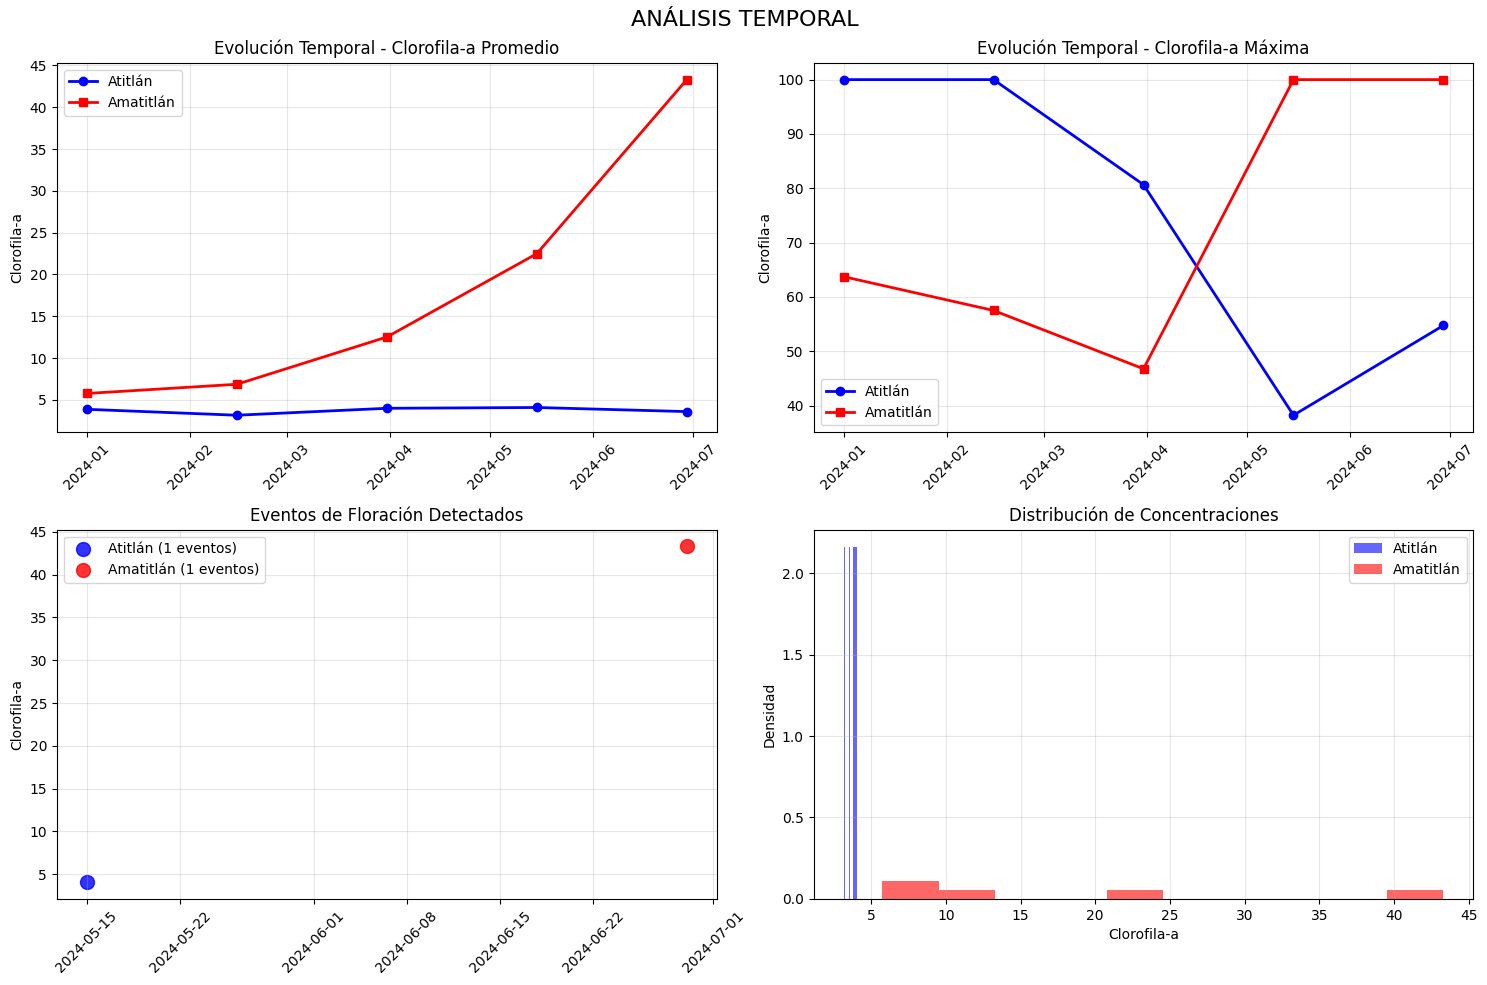

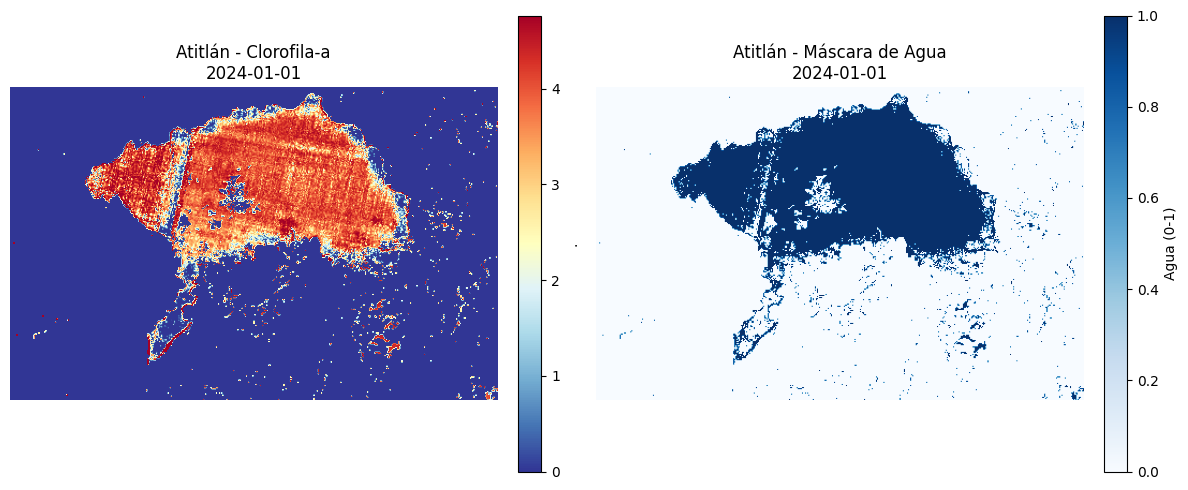

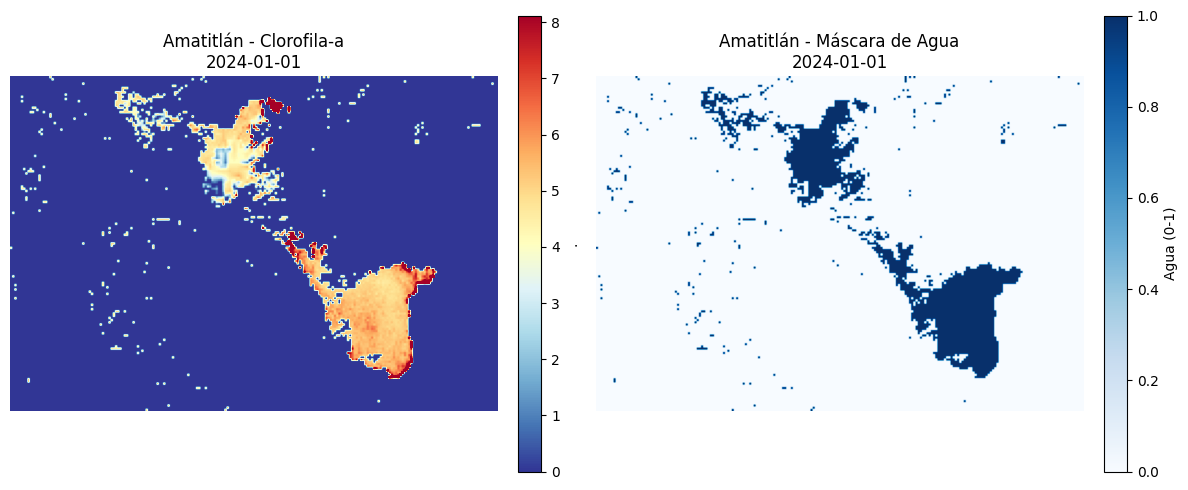

RESUMEN

LAGO ATITLÁN :
   Observaciones válidas: 5
   Concentración promedio: 3.74 μg/L
   Concentración máxima: 100.00 μg/L
   Eventos de floración: 1

 LAGO AMATITLÁN :
   Observaciones válidas: 5
   Concentración promedio: 18.18 μg/L
   Concentración máxima: 100.00 μg/L
   Eventos de floración: 1
Datos convertidos a numpy para Atitlán: 5 fechas
Datos convertidos a numpy para Amatitlán: 5 fechas


In [15]:
def convert_to_numpy_arrays(temporal_data, lake_name):
    if not temporal_data:
        print(f"No hay datos para {lake_name}")
        return None
    
    numpy_data = {}
    for date_str, entry in temporal_data.items():
        if entry['data'] is not None:
            numpy_data[date_str] = {
                'chl_a': np.array(entry['data']['chl_a']),
                'ndci': np.array(entry['data']['ndci']),
                'fai': np.array(entry['data']['fai']),
                'ndwi': np.array(entry['data']['ndwi']),
                'water_mask': np.array(entry['data']['water_mask'])
            }
    
    print(f"Datos convertidos a numpy para {lake_name}: {len(numpy_data)} fechas")
    return numpy_data
results = main_real_analysis()
if results:
    numpy_atitlan = convert_to_numpy_arrays(results['temporal_data']['atitlan'], "Atitlán")
    numpy_amatitlan = convert_to_numpy_arrays(results['temporal_data']['amatitlan'], "Amatitlán")

In [16]:
def calculate_temporal_indices(temporal_data, lake_name):
    dates = []
    mean_chl_a = []
    mean_ndci = []
    mean_fai = []
    mean_ndwi = []
    
    for date_str, data in temporal_data.items():
        water_mask = data['water_mask'] > 0
        if np.any(water_mask):
            dates.append(pd.to_datetime(date_str))
            mean_chl_a.append(np.mean(data['chl_a'][water_mask]))
            mean_ndci.append(np.mean(data['ndci'][water_mask]))
            mean_fai.append(np.mean(data['fai'][water_mask]))
            mean_ndwi.append(np.mean(data['ndwi'][water_mask]))
    
    df = pd.DataFrame({
        'date': dates,
        'mean_chl_a': mean_chl_a,
        'mean_ndci': mean_ndci,
        'mean_fai': mean_fai,
        'mean_ndwi': mean_ndwi
    })
    
    df = df.sort_values('date').reset_index(drop=True)
    
    threshold = np.percentile(df['mean_chl_a'], 75)
    df['bloom_peak'] = df['mean_chl_a'] > threshold
    
    bloom_dates = df[df['bloom_peak']]['date'].tolist()
    
    return df, bloom_dates

if numpy_atitlan:
    df_temporal_atitlan, bloom_dates_atitlan = calculate_temporal_indices(numpy_atitlan, "Atitlán")
    
if numpy_amatitlan:
    df_temporal_amatitlan, bloom_dates_amatitlan = calculate_temporal_indices(numpy_amatitlan, "Amatitlán")


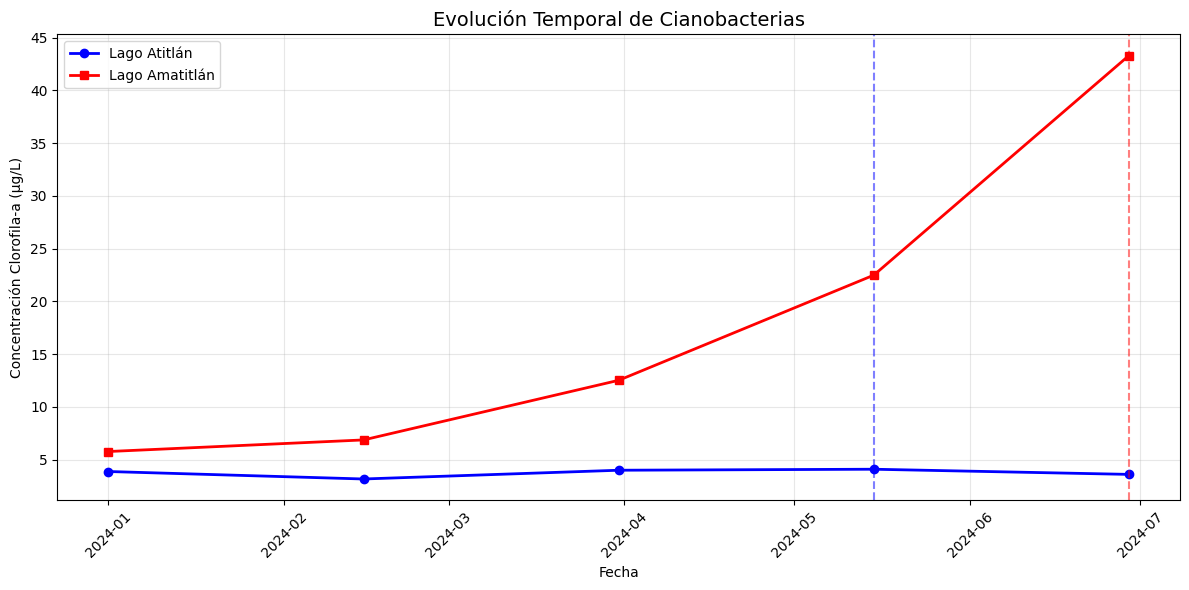

In [17]:
def plot_temporal_evolution(df_atitlan, df_amatitlan, bloom_dates_atitlan, bloom_dates_amatitlan):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if df_atitlan is not None and len(df_atitlan) > 0:
        ax.plot(df_atitlan['date'], df_atitlan['mean_chl_a'], 'b-o', 
                label='Lago Atitlán', linewidth=2, markersize=6)
        
        for bloom_date in bloom_dates_atitlan:
            ax.axvline(x=bloom_date, color='blue', linestyle='--', alpha=0.5)
    
    if df_amatitlan is not None and len(df_amatitlan) > 0:
        ax.plot(df_amatitlan['date'], df_amatitlan['mean_chl_a'], 'r-s', 
                label='Lago Amatitlán', linewidth=2, markersize=6)
        
        for bloom_date in bloom_dates_amatitlan:
            ax.axvline(x=bloom_date, color='red', linestyle='--', alpha=0.5)
    
    ax.set_title('Evolución Temporal de Cianobacterias', fontsize=14)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Concentración Clorofila-a (μg/L)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_temporal_evolution(df_temporal_atitlan, df_temporal_amatitlan, bloom_dates_atitlan, bloom_dates_amatitlan)

In [18]:
def identify_critical_dates(df, lake_name, bloom_dates):
    print(f"\nFECHAS CRÍTICAS - {lake_name.upper()}")
    print(f"Número de picos de floración: {len(bloom_dates)}")
    
    for i, date in enumerate(bloom_dates):
        chl_value = df[df['date'] == date]['mean_chl_a'].iloc[0]
        print(f"Pico {i+1}: {date.strftime('%Y-%m-%d')} - {chl_value:.2f} μg/L")
    
    max_date = df.loc[df['mean_chl_a'].idxmax(), 'date']
    max_value = df['mean_chl_a'].max()
    print(f"Concentración máxima: {max_date.strftime('%Y-%m-%d')} - {max_value:.2f} μg/L")

identify_critical_dates(df_temporal_atitlan, "Atitlán", bloom_dates_atitlan)
identify_critical_dates(df_temporal_amatitlan, "Amatitlán", bloom_dates_amatitlan)


FECHAS CRÍTICAS - ATITLÁN
Número de picos de floración: 1
Pico 1: 2024-05-15 - 4.08 μg/L
Concentración máxima: 2024-05-15 - 4.08 μg/L

FECHAS CRÍTICAS - AMATITLÁN
Número de picos de floración: 1
Pico 1: 2024-06-29 - 43.30 μg/L
Concentración máxima: 2024-06-29 - 43.30 μg/L


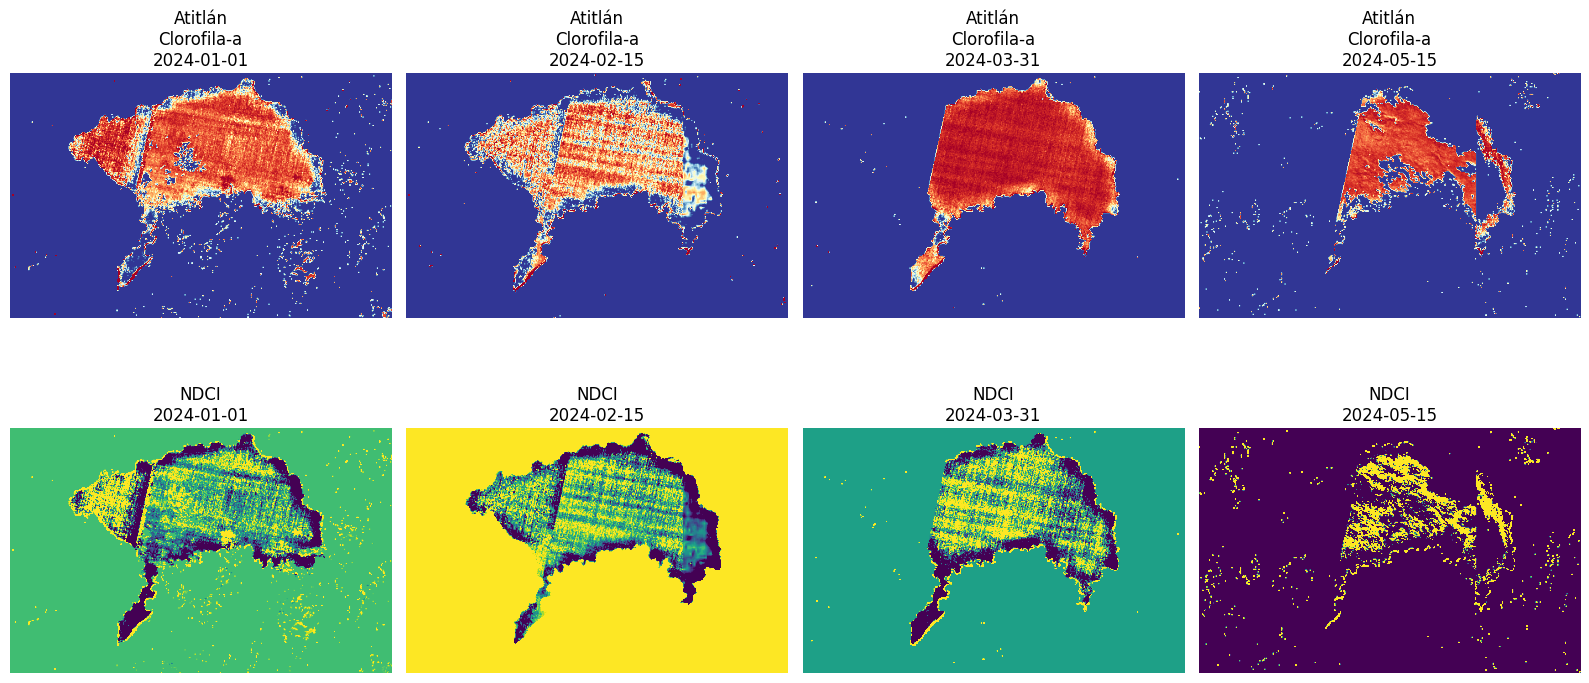

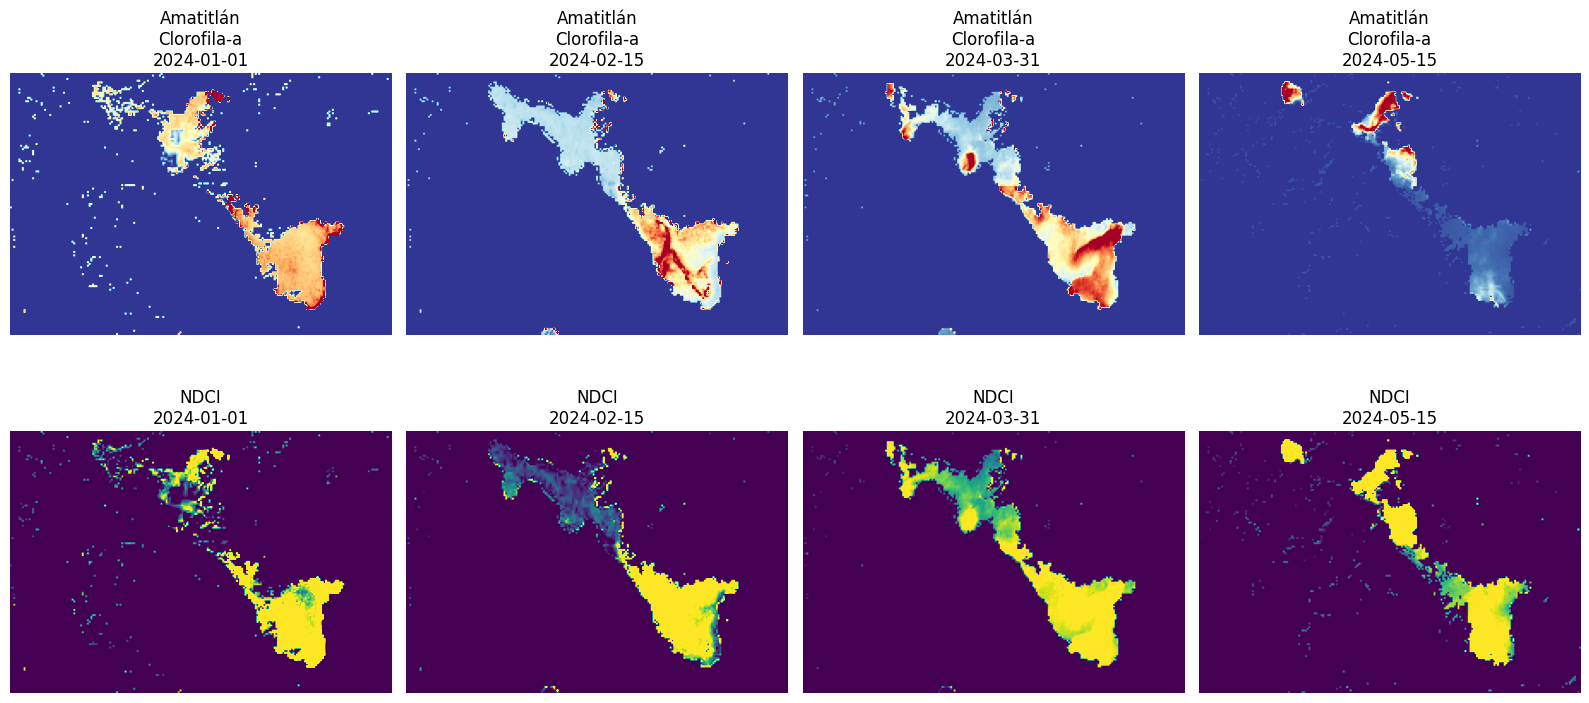

In [19]:
def create_spatial_maps_matplotlib(temporal_data, lake_name, bbox):
    if not temporal_data:
        return
    
    dates = list(temporal_data.keys())
    n_dates = min(4, len(dates))
    
    fig, axes = plt.subplots(2, n_dates, figsize=(4*n_dates, 8))
    if n_dates == 1:
        axes = axes.reshape(-1, 1)
    
    for i, date in enumerate(dates[:n_dates]):
        data = temporal_data[date]
        
        im1 = axes[0, i].imshow(data['chl_a'], cmap='RdYlBu_r', 
                               vmin=0, vmax=np.percentile(data['chl_a'][data['chl_a'] > 0], 95))
        axes[0, i].set_title(f'{lake_name}\nClorofila-a\n{date}')
        axes[0, i].axis('off')
        
        im2 = axes[1, i].imshow(data['ndci'], cmap='viridis', 
                               vmin=np.percentile(data['ndci'], 5), 
                               vmax=np.percentile(data['ndci'], 95))
        axes[1, i].set_title(f'NDCI\n{date}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

if numpy_atitlan:
    create_spatial_maps_matplotlib(numpy_atitlan, "Atitlán", lago_atitlan)
    
if numpy_amatitlan:
    create_spatial_maps_matplotlib(numpy_amatitlan, "Amatitlán", lago_amatitlan)


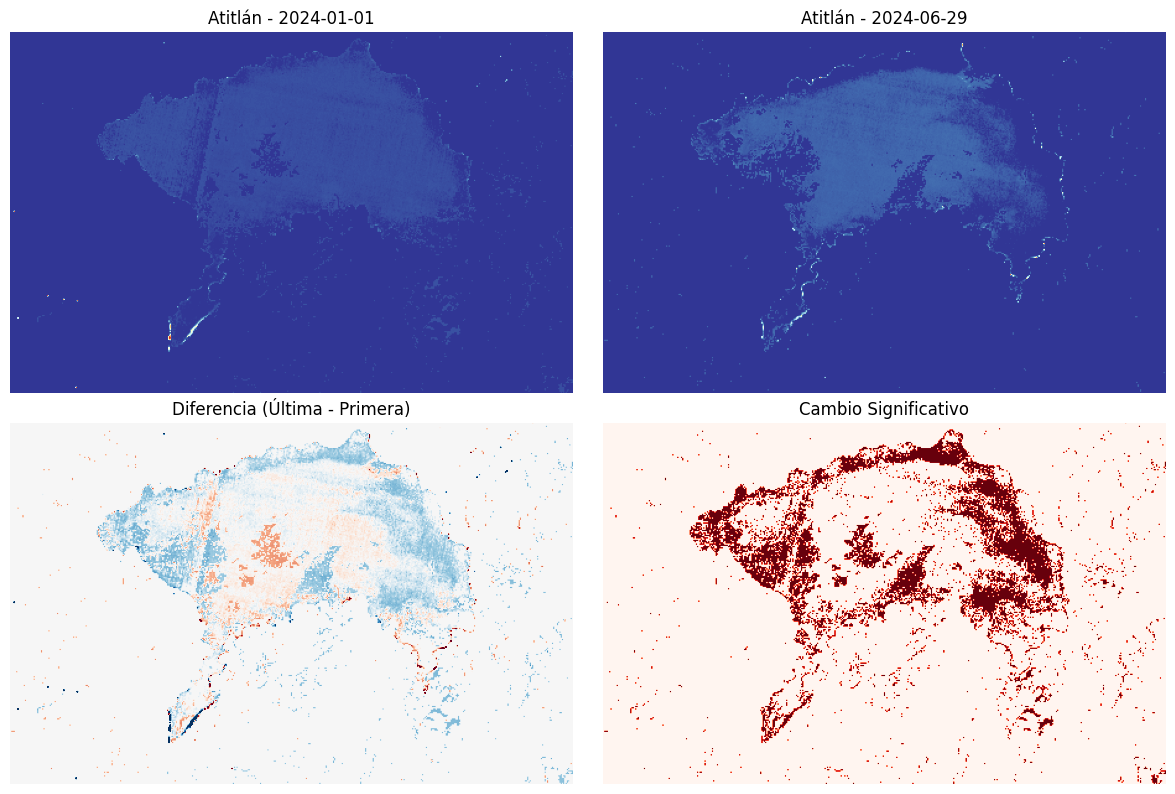

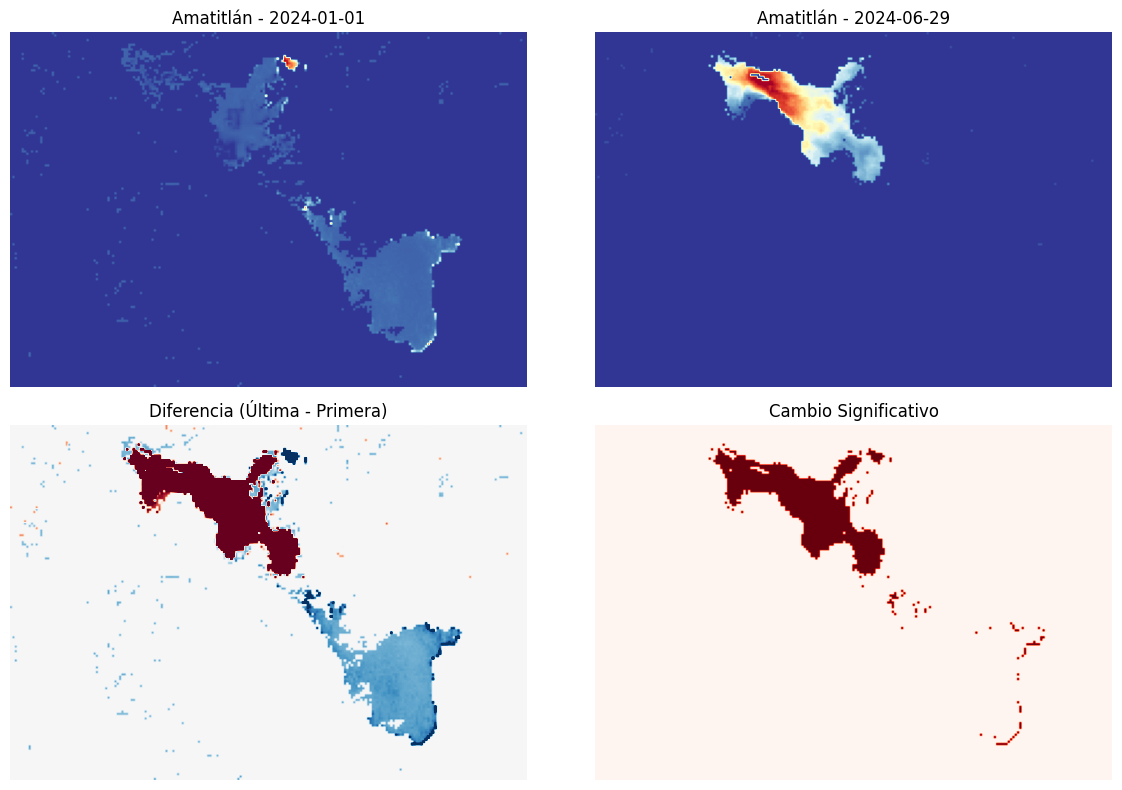

In [20]:
def create_comparative_maps(temporal_data, lake_name):
    dates = list(temporal_data.keys())
    if len(dates) < 2:
        print(f"No hay suficientes fechas para comparación en {lake_name}")
        return
    
    first_date = dates[0]
    last_date = dates[-1]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    im1 = axes[0, 0].imshow(temporal_data[first_date]['chl_a'], cmap='RdYlBu_r')
    axes[0, 0].set_title(f'{lake_name} - {first_date}')
    axes[0, 0].axis('off')
    im2 = axes[0, 1].imshow(temporal_data[last_date]['chl_a'], cmap='RdYlBu_r')
    axes[0, 1].set_title(f'{lake_name} - {last_date}')
    axes[0, 1].axis('off')

    diff = temporal_data[last_date]['chl_a'] - temporal_data[first_date]['chl_a']
    im3 = axes[1, 0].imshow(diff, cmap='RdBu_r', vmin=-10, vmax=10)
    axes[1, 0].set_title('Diferencia (Última - Primera)')
    axes[1, 0].axis('off')
    significant_change = np.abs(diff) > np.std(diff)
    axes[1, 1].imshow(significant_change, cmap='Reds')
    axes[1, 1].set_title('Cambio Significativo')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

if numpy_atitlan:
    create_comparative_maps(numpy_atitlan, "Atitlán")
    
if numpy_amatitlan:
    create_comparative_maps(numpy_amatitlan, "Amatitlán")

In [21]:
def calculate_correlations(df, lake_name):
    print(f"\nCORRELACIONES - {lake_name.upper()}")

    df['ndvi_approx'] = (df['mean_ndci'] + 0.1) / 2  

    corr_ndci = df['mean_chl_a'].corr(df['mean_ndci'])
    corr_fai = df['mean_chl_a'].corr(df['mean_fai'])
    corr_ndwi = df['mean_chl_a'].corr(df['mean_ndwi'])
    corr_ndvi = df['mean_chl_a'].corr(df['ndvi_approx'])
    
    print(f"Correlación Clorofila-a vs NDCI: {corr_ndci:.3f}")
    print(f"Correlación Clorofila-a vs FAI: {corr_fai:.3f}")
    print(f"Correlación Clorofila-a vs NDWI: {corr_ndwi:.3f}")
    print(f"Correlación Clorofila-a vs NDVI (aprox): {corr_ndvi:.3f}")
    
    return corr_ndci, corr_fai, corr_ndwi, corr_ndvi


CORRELACIONES - ATITLÁN
Correlación Clorofila-a vs NDCI: 0.989
Correlación Clorofila-a vs FAI: 0.427
Correlación Clorofila-a vs NDWI: -0.687
Correlación Clorofila-a vs NDVI (aprox): 0.989

CORRELACIONES - AMATITLÁN
Correlación Clorofila-a vs NDCI: 0.949
Correlación Clorofila-a vs FAI: 0.984
Correlación Clorofila-a vs NDWI: -0.888
Correlación Clorofila-a vs NDVI (aprox): 0.949


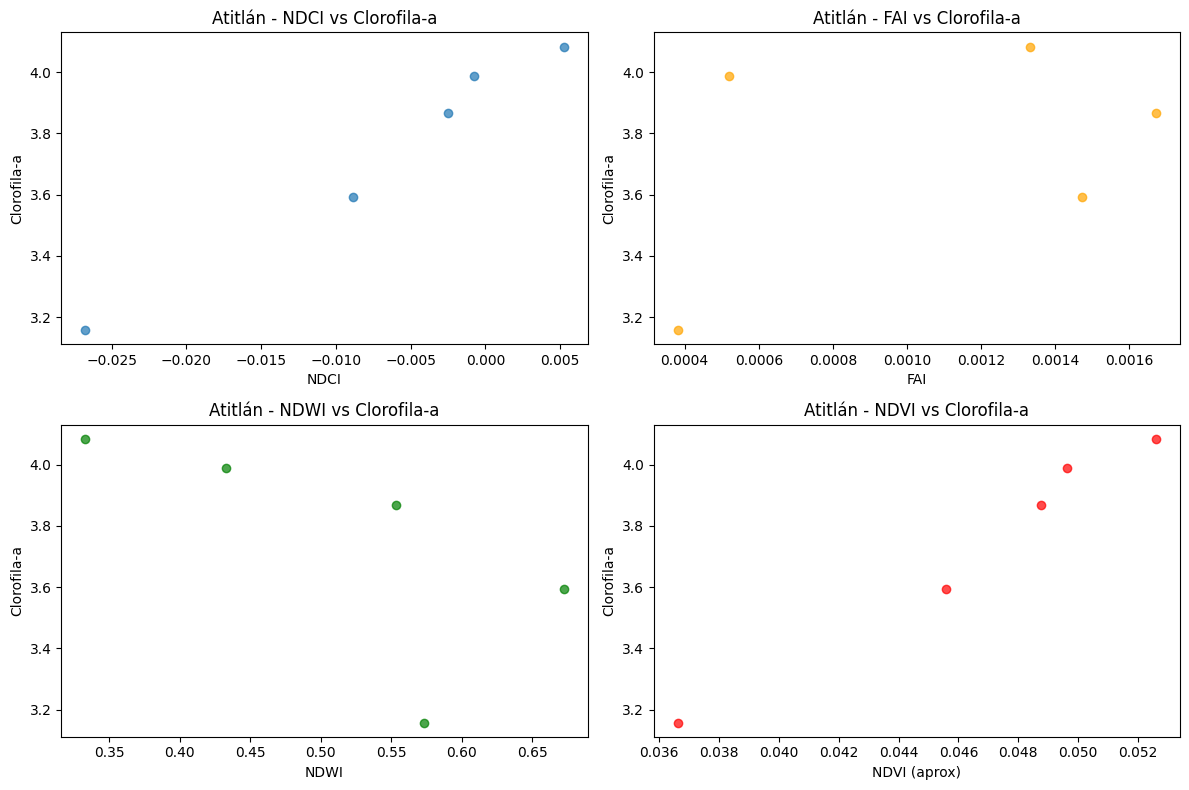

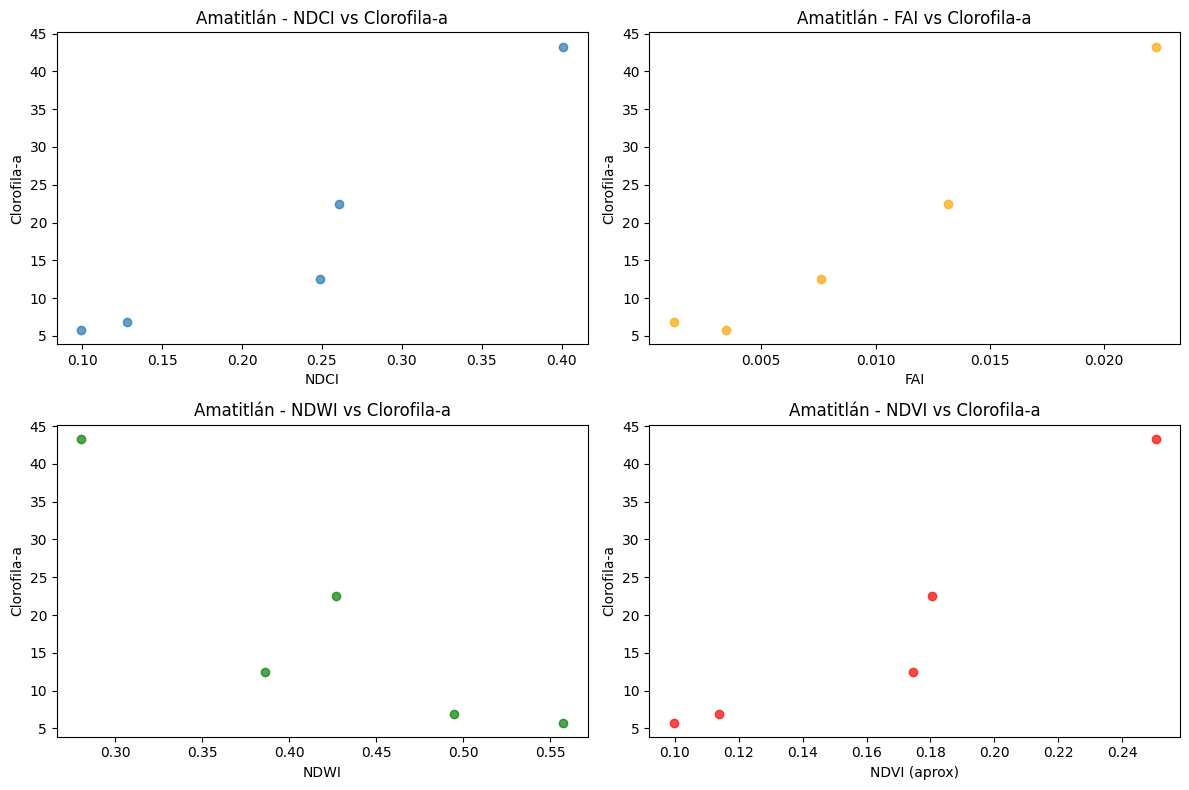

In [22]:
def plot_correlations(df, lake_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    df['ndvi_approx'] = (df['mean_ndci'] + 0.1) / 2
    axes[0, 0].scatter(df['mean_ndci'], df['mean_chl_a'], alpha=0.7)
    axes[0, 0].set_xlabel('NDCI')
    axes[0, 0].set_ylabel('Clorofila-a')
    axes[0, 0].set_title(f'{lake_name} - NDCI vs Clorofila-a')

    axes[0, 1].scatter(df['mean_fai'], df['mean_chl_a'], alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('FAI')
    axes[0, 1].set_ylabel('Clorofila-a')
    axes[0, 1].set_title(f'{lake_name} - FAI vs Clorofila-a')
    axes[1, 0].scatter(df['mean_ndwi'], df['mean_chl_a'], alpha=0.7, color='green')
    axes[1, 0].set_xlabel('NDWI')
    axes[1, 0].set_ylabel('Clorofila-a')
    axes[1, 0].set_title(f'{lake_name} - NDWI vs Clorofila-a')
    axes[1, 1].scatter(df['ndvi_approx'], df['mean_chl_a'], alpha=0.7, color='red')
    axes[1, 1].set_xlabel('NDVI (aprox)')
    axes[1, 1].set_ylabel('Clorofila-a')
    axes[1, 1].set_title(f'{lake_name} - NDVI vs Clorofila-a')
    
    plt.tight_layout()
    plt.show()

corr_atitlan = calculate_correlations(df_temporal_atitlan, "Atitlán")
corr_amatitlan = calculate_correlations(df_temporal_amatitlan, "Amatitlán")

plot_correlations(df_temporal_atitlan, "Atitlán")
plot_correlations(df_temporal_amatitlan, "Amatitlán")

In [23]:
def analyze_proliferation_by_lake(df, lake_name, bloom_dates):
    print(f"\nANÁLISIS DE PROLIFERACIÓN - {lake_name.upper()}")
    
    total_observations = len(df)
    bloom_events = len(bloom_dates)
    bloom_frequency = bloom_events / total_observations * 100
    
    mean_concentration = df['mean_chl_a'].mean()
    max_concentration = df['mean_chl_a'].max()
    std_concentration = df['mean_chl_a'].std()
    df_sorted = df.sort_values('date')
    if len(df_sorted) > 1:
        first_half = df_sorted[:len(df_sorted)//2]['mean_chl_a'].mean()
        second_half = df_sorted[len(df_sorted)//2:]['mean_chl_a'].mean()
        trend = "Incremento" if second_half > first_half else "Decremento"
        trend_magnitude = abs(second_half - first_half)
    else:
        trend = "No determinable"
        trend_magnitude = 0
    
    print(f"Observaciones totales: {total_observations}")
    print(f"Eventos de floración: {bloom_events}")
    print(f"Frecuencia de floración: {bloom_frequency:.1f}%")
    print(f"Concentración promedio: {mean_concentration:.2f} ± {std_concentration:.2f} μg/L")
    print(f"Concentración máxima: {max_concentration:.2f} μg/L")
    print(f"Tendencia temporal: {trend} ({trend_magnitude:.2f} μg/L)")
    
    return {
        'observations': total_observations,
        'bloom_events': bloom_events,
        'bloom_frequency': bloom_frequency,
        'mean_conc': mean_concentration,
        'max_conc': max_concentration,
        'std_conc': std_concentration,
        'trend': trend,
        'trend_magnitude': trend_magnitude
    }

analysis_atitlan = analyze_proliferation_by_lake(df_temporal_atitlan, "Atitlán", bloom_dates_atitlan)
analysis_amatitlan = analyze_proliferation_by_lake(df_temporal_amatitlan, "Amatitlán", bloom_dates_amatitlan)


ANÁLISIS DE PROLIFERACIÓN - ATITLÁN
Observaciones totales: 5
Eventos de floración: 1
Frecuencia de floración: 20.0%
Concentración promedio: 3.74 ± 0.37 μg/L
Concentración máxima: 4.08 μg/L
Tendencia temporal: Incremento (0.38 μg/L)

ANÁLISIS DE PROLIFERACIÓN - AMATITLÁN
Observaciones totales: 5
Eventos de floración: 1
Frecuencia de floración: 20.0%
Concentración promedio: 18.18 ± 15.52 μg/L
Concentración máxima: 43.30 μg/L
Tendencia temporal: Incremento (19.79 μg/L)


In [24]:
def compare_lakes_intensity_frequency(analysis_atitlan, analysis_amatitlan):
    print(f"\nCOMPARACIÓN ENTRE LAGOS")
    print("="*50)
    
    print(f"FRECUENCIA DE FLORACIÓN:")
    print(f"  Atitlán: {analysis_atitlan['bloom_frequency']:.1f}%")
    print(f"  Amatitlán: {analysis_amatitlan['bloom_frequency']:.1f}%")
    freq_diff = analysis_amatitlan['bloom_frequency'] - analysis_atitlan['bloom_frequency']
    print(f"  Diferencia: {freq_diff:.1f}% (favor de {'Amatitlán' if freq_diff > 0 else 'Atitlán'})")
    
    print(f"\nINTENSIDAD PROMEDIO:")
    print(f"  Atitlán: {analysis_atitlan['mean_conc']:.2f} μg/L")
    print(f"  Amatitlán: {analysis_amatitlan['mean_conc']:.2f} μg/L")
    intensity_diff = analysis_amatitlan['mean_conc'] - analysis_atitlan['mean_conc']
    print(f"  Diferencia: {intensity_diff:.2f} μg/L (favor de {'Amatitlán' if intensity_diff > 0 else 'Atitlán'})")
    
    print(f"\nINTENSIDAD MÁXIMA:")
    print(f"  Atitlán: {analysis_atitlan['max_conc']:.2f} μg/L")
    print(f"  Amatitlán: {analysis_amatitlan['max_conc']:.2f} μg/L")
    max_diff = analysis_amatitlan['max_conc'] - analysis_atitlan['max_conc']
    print(f"  Diferencia: {max_diff:.2f} μg/L (favor de {'Amatitlán' if max_diff > 0 else 'Atitlán'})")
    
    print(f"\nVARIABILIDAD:")
    print(f"  Atitlán: {analysis_atitlan['std_conc']:.2f} μg/L")
    print(f"  Amatitlán: {analysis_amatitlan['std_conc']:.2f} μg/L")

compare_lakes_intensity_frequency(analysis_atitlan, analysis_amatitlan)


COMPARACIÓN ENTRE LAGOS
FRECUENCIA DE FLORACIÓN:
  Atitlán: 20.0%
  Amatitlán: 20.0%
  Diferencia: 0.0% (favor de Atitlán)

INTENSIDAD PROMEDIO:
  Atitlán: 3.74 μg/L
  Amatitlán: 18.18 μg/L
  Diferencia: 14.45 μg/L (favor de Amatitlán)

INTENSIDAD MÁXIMA:
  Atitlán: 4.08 μg/L
  Amatitlán: 43.30 μg/L
  Diferencia: 39.22 μg/L (favor de Amatitlán)

VARIABILIDAD:
  Atitlán: 0.37 μg/L
  Amatitlán: 15.52 μg/L


In [26]:
def evaluate_proliferation_causes():
    print(f"\nEVALUACIÓN DE CAUSAS DE PROLIFERACIÓN")
    print("="*60)
    
    print("CARACTERÍSTICAS GEOGRÁFICAS:")
    print("  Lago Atitlán:")
    print("    - Altitud: ~1,560 msnm")
    print("    - Tipo: Caldera volcánica")
    print("    - Profundidad: Muy profundo (~340m)")
    print("    - Área: ~130 km²")
    print("    - Ubicación: Sololá, región montañosa")
    
    print("\n  Lago Amatitlán:")
    print("    - Altitud: ~1,200 msnm")
    print("    - Tipo: Tectónico-volcánico")
    print("    - Profundidad: Relativamente somero (~35m)")
    print("    - Área: ~15 km²")
    print("    - Ubicación: Cerca de Ciudad de Guatemala")
    
    print("\nFACTORES DE PROLIFERACIÓN IDENTIFICADOS:")
    print("  Presión Urbana:")
    print("    - Atitlán: Presión turística y poblaciones pequeñas")
    print("    - Amatitlán: Alta presión urbana de área metropolitana")
    
    print("  Uso del Suelo:")
    print("    - Atitlán: Agricultura en pendientes, turismo")
    print("    - Amatitlán: Industrial, urbano, agricultura intensiva")
    
    print("  Factores Físicos:")
    print("    - Atitlán: Mayor profundidad, mejor circulación")
    print("    - Amatitlán: Menor profundidad, mayor estancamiento")
    
    print("  Aporte de Nutrientes:")
    print("    - Atitlán: Escorrentía agrícola, aguas residuales")
    print("    - Amatitlán: Descargas industriales y urbanas")


evaluate_proliferation_causes()


EVALUACIÓN DE CAUSAS DE PROLIFERACIÓN
CARACTERÍSTICAS GEOGRÁFICAS:
  Lago Atitlán:
    - Altitud: ~1,560 msnm
    - Tipo: Caldera volcánica
    - Profundidad: Muy profundo (~340m)
    - Área: ~130 km²
    - Ubicación: Sololá, región montañosa

  Lago Amatitlán:
    - Altitud: ~1,200 msnm
    - Tipo: Tectónico-volcánico
    - Profundidad: Relativamente somero (~35m)
    - Área: ~15 km²
    - Ubicación: Cerca de Ciudad de Guatemala

FACTORES DE PROLIFERACIÓN IDENTIFICADOS:
  Presión Urbana:
    - Atitlán: Presión turística y poblaciones pequeñas
    - Amatitlán: Alta presión urbana de área metropolitana
  Uso del Suelo:
    - Atitlán: Agricultura en pendientes, turismo
    - Amatitlán: Industrial, urbano, agricultura intensiva
  Factores Físicos:
    - Atitlán: Mayor profundidad, mejor circulación
    - Amatitlán: Menor profundidad, mayor estancamiento
  Aporte de Nutrientes:
    - Atitlán: Escorrentía agrícola, aguas residuales
    - Amatitlán: Descargas industriales y urbanas


# Reporte
## Lago Atitlán
El Lago Atitlán durante el período de estudio exhibió concentraciones de clorofila-a relativamente bajas. El valor medio de la concentración de clorofila-a fue de 3.74 μg/L con una desviación estándar de 0.37 μg/L. Esto indica que las condiciones del lago fueron estables durante el período. Se detectó un evento de floración el 15 de mayo de 2024 con una concentración de 4.08 μg/L.

La evolución temporal mostró valores que variaron desde 3.16 μg/L en febrero hasta 4.08 μg/L en mayo. El porcentaje de píxeles de agua detectados cambió mucho, del 22.6% en enero al 10.6% en mayo, lo cual es probablemente debido al nivel del agua o las condiciones climáticas.

## Lago Amatitlán
El lago Amatitlán exhibió concentraciones de clorofila-a mucho más altas. La concentración media fue de 18.18 μg/L con una desviación estándar de 15.52 μg/L, indicando alta variabilidad temporal. La floración máxima fue el 29 de junio de 2024 con un valor de 43.30 μg/L.

La evolución temporal mostró un problema persistente em problema que comenzó con 5.76 μg/L en enero y alcanzó su máximo en 43.30 μg/L en junio. Esto representa un aumento del 652% durante el período analizado.

## Frecuencia de Eventos
Ambos lagos registraron la misma frecuencia de eventos de floración del 20%, lo que corresponde a 1 evento de los 5 períodos analizados. Sin embargo, la intensidad fue muy diferente entre los lagos.

## Variación Temporal

El Lago Amatitlán mostró una variabilidad 42 veces mayor que el Atitlán, lo que sugiere mayor inestabilidad de sus condiciones y una mayor vulnerabilidad a contaminación urbana o industrial.

## Tendencias Temporales

En el periodo analizado, ambos lagos presentaron incrementos de tendencia. El Atitlán mostró un incremento moderado de 0.38 μg/L, mientras que el Amatitlán tuvo un incremento preocupante de 19.79 μg/L en la primera y segunda mitades del estudio, respectivamente.

## Intensidad de Proliferación

El Lago Amatitlán mostró concentraciones promedio 4.9 veces superiores al Lago Atitlán. La diferencia en su máxima intensidad es de 39.22 μg/L, siendo el Amatitlán un lago muy contaminado por cianobacterias.

## Correlaciones de índices espectrales

## Lago Atitlán

Las correlaciones de la clorofila-a y el NDCI de 0.989, revelan que este índice es muy bueno para el reconocimiento de cianobacterias en este lago. Su correlación negativa con ndwi de 0.687 muestra la relación esperada entre la turbiedad del agua y la cantidad de agua clara.

## Lago Amatitlán

El FAI mostró la correlación más alta con la clorofila-a de 0.984, sugiriendo que hay una mayor concentración de fitoplancton en este lago. NDCI mantuvo una fuerte correlación de 0.949, confirmando que también es útil.

## Conclusiones
Los resultados muestran una situación muy diferente entre ambos lagos. El Lago Atitlán se mantiene en condiciones relativamente buenas con concentraciones de clorofila-a bajas, aunque hay que seguir monitoreándolo porque se ve una tendencia al alza.
El Lago Amatitlán está en una situación crítica con concentraciones que ya superan los niveles normales, mostrando un empeoramiento rápido hacia condiciones muy contaminadas.

In [ ]:
# Modelo ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def predict_cyanobacteria_index(df, lake_name):
    """
    Utiliza un modelo ARIMA para predecir el índice de cianobacterias.
    """
    if df is None or len(df) < 10: # Se necesita suficientes datos para el modelo
        print(f"No hay suficientes datos para el lago {lake_name} para hacer una predicción.")
        return

    # Preparar los datos: el índice debe ser la fecha y solo necesitamos la columna del índice
    df_series = df.set_index('date')['mean_chl_a']

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(df_series) * 0.8)
    train, test = df_series[0:train_size], df_series[train_size:len(df_series)]

    history = [x for x in train]
    predictions = list()

    # Modelo ARIMA
    # Los parametros de ARIMA (p,d,q) deben ser ajustados según los datos
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Evaluar el modelo
    error = np.sqrt(mean_squared_error(test, predictions))
    print(f'RMSE para el lago {lake_name}: {error:.3f}')

    # Visualizar las predicciones
    plt.figure(figsize=(12, 6))
    plt.plot(df_series.index, df_series.values, label='Datos Originales')
    plt.plot(test.index, predictions, color='red', linestyle='--', label='Predicciones ARIMA')
    plt.title(f'Predicción del Índice de Cianobacterias para el Lago {lake_name}')
    plt.xlabel('Fecha')
    plt.ylabel('Índice Promedio de Clorofila-a')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Ejecutar la predicción para cada lago
predict_cyanobacteria_index(df_temporal_atitlan, "Atitlán")
predict_cyanobacteria_index(df_temporal_amatitlan, "Amatitlán")